In [ ]:
import random
import string
import cv2
from google.colab.patches import cv2_imshow
import numpy as np

def random_string(K):
    return ''.join(random.choice(string.ascii_letters) for i in range(K))

In [ ]:
def hough_transform(edges, delta_rho=30, delta_theta=np.pi/2, threshold=50, num_lines=15):
    height, width = edges.shape
    max_rho = int(np.sqrt(height**2 + width**2))
    accumulator = np.zeros((2*max_rho, 180), dtype=np.uint64)

    for y in range(height):
        for x in range(width):
            if edges[y, x] > 0:
                for theta in range(0, 180):
                    rho = int(x * np.cos(np.radians(theta)) + y * np.sin(np.radians(theta)))
                    accumulator[rho + max_rho, theta] += 1

    peaks = np.argwhere(accumulator > threshold)
    sorted_peaks = peaks[np.argsort(accumulator[peaks[:, 0], peaks[:, 1]])[::-1]][:num_lines]
    num_votes = []
    file1 = open(random_string(3)+'.txt', 'w+')

    for i in range(len(sorted_peaks)):
      rho2, theta2 = sorted_peaks[i][0], sorted_peaks[i][1]
      nv = accumulator[rho2][theta2]
      num_votes.append(nv)
      file1.write(str(rho2) + " ")
      file1.write(str(theta2) + " ")
      file1.write(str(nv) + "\n")

    result_image = cv2.cvtColor(edges, cv2.COLOR_GRAY2BGR)
    for peak in sorted_peaks:
        rho, theta = peak[0] - max_rho, peak[1]
        a = np.cos(np.radians(theta))
        b = np.sin(np.radians(theta))
        x0 = a * rho
        y0 = b * rho
        x1 = int(x0 + 1000 * (-b))
        y1 = int(y0 + 1000 * (a))
        x2 = int(x0 - 1000 * (-b))
        y2 = int(y0 - 1000 * (a))
        cv2.line(result_image, (x1, y1), (x2, y2), (0, 0, 255), 2)

    return accumulator, result_image

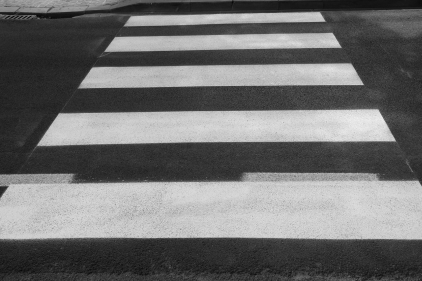

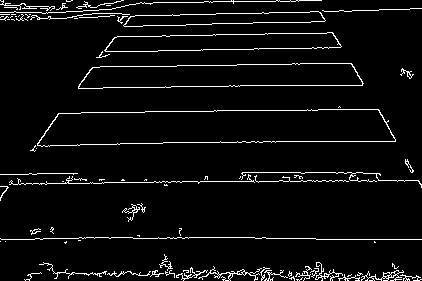

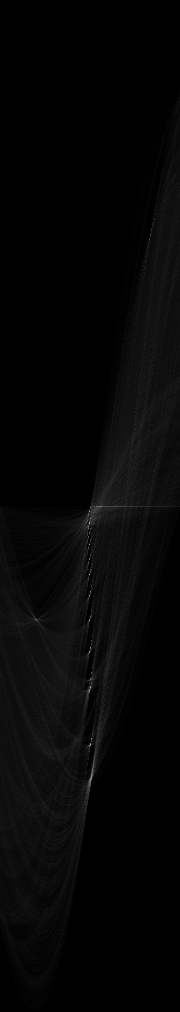

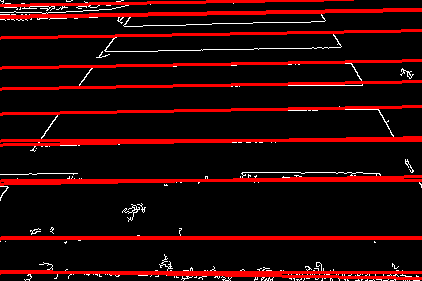

In [ ]:
image = cv2.imread('crosswalk.png', cv2.IMREAD_GRAYSCALE)
edges = cv2.Canny(image, 50, 150)
accumulator, result_image = hough_transform(edges)
cv2_imshow(image)
cv2_imshow(edges)
cv2_imshow(accumulator.astype(np.uint8))
cv2_imshow(result_image)

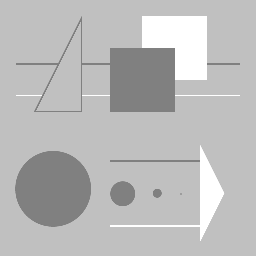

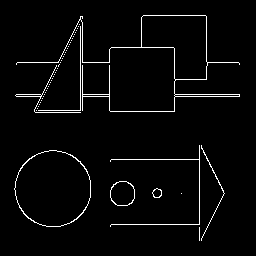

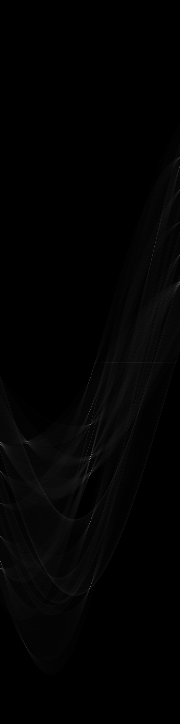

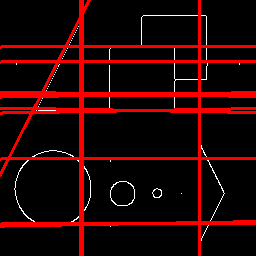

In [ ]:
image = cv2.imread('edges-lines-orig.png', cv2.IMREAD_GRAYSCALE)
edges = cv2.Canny(image, 50, 150)
accumulator, result_image = hough_transform(edges)
cv2_imshow(image)
cv2_imshow(edges)
cv2_imshow(accumulator.astype(np.uint8))
cv2_imshow(result_image)

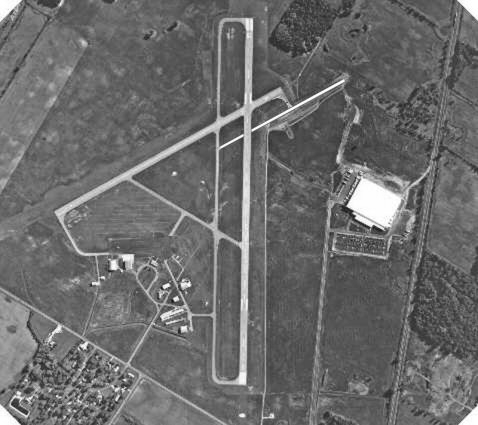

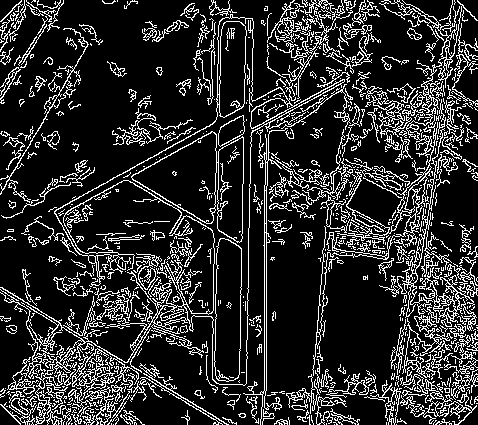

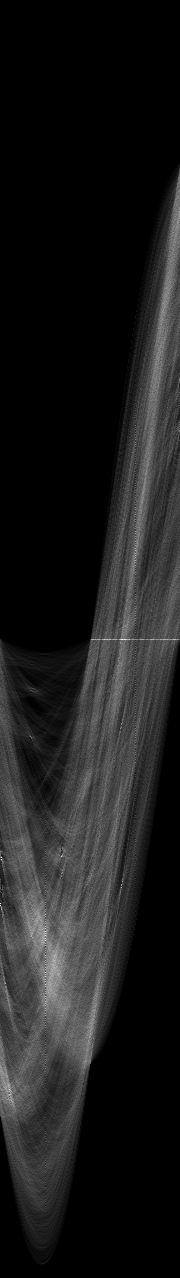

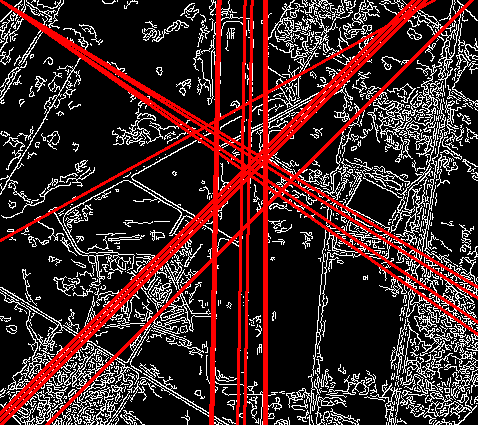

In [ ]:
image = cv2.imread('mnn4-runway-Ohio.jpg', cv2.IMREAD_GRAYSCALE)
edges = cv2.Canny(image, 50, 150)
accumulator, result_image = hough_transform(edges)
cv2_imshow(image)
cv2_imshow(edges)
cv2_imshow(accumulator.astype(np.uint8))
cv2_imshow(result_image)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]] [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[336   1]
 [337   1]
 [338   1]
 [335   1]
 [339   1]]
[[ 22   0  24 ...   0   0 105]
 [ 30   0  24 ...   0   0 108]
 [ 39   0  28 ...   0   0 116]
 ...
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]]


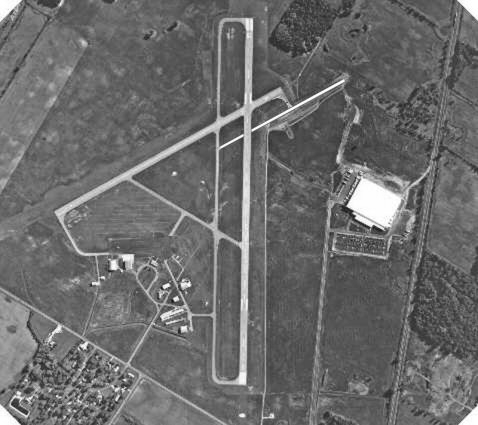

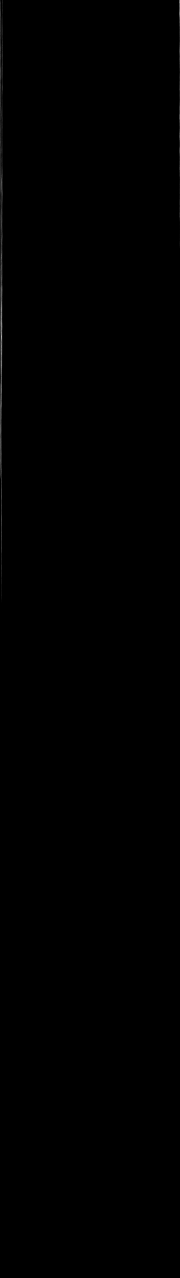

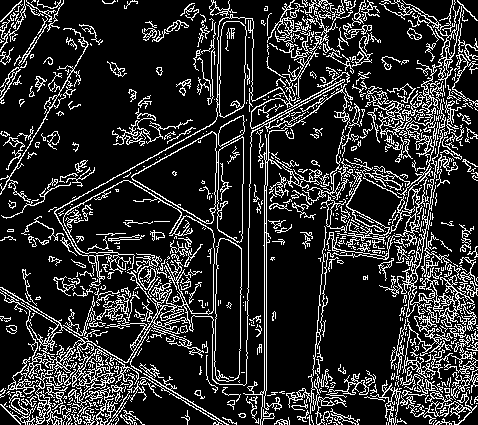

In [ ]:
def hough_transform_with_orientation(edges, delta_rho=1, delta_theta=np.pi/180, threshold=20, num_lines=5, neighborhood_size=5):
    height, width = edges.shape
    max_rho = int(np.sqrt(height**2 + width**2))
    accumulator = np.zeros((2*max_rho, 180), dtype=np.uint64)

    dx, dy = cv2.Sobel(edges, cv2.CV_64F, 1, 0, ksize=3), cv2.Sobel(edges, cv2.CV_64F, 0, 1, ksize=3)
    print(dx, dy)
    edge_orientation = np.arctan2(dy, dx)
    print(edge_orientation)

    for y in range(height):
        for x in range(width):
            if edges[y, x] > 0:
                orientation = edge_orientation[y, x]
                for theta in range(int(orientation - np.pi/6), int(orientation + np.pi/6)):
                    for rho in range(int(x * np.cos(theta) + y * np.sin(theta)) - neighborhood_size//2,
                                     int(x * np.cos(theta) + y * np.sin(theta)) + neighborhood_size//2 + 1):
                        if 0 <= rho < 2*max_rho:
                            accumulator[rho, theta % 180] += 1

    peaks = np.argwhere(accumulator > threshold)
    sorted_peaks = peaks[np.argsort(accumulator[peaks[:, 0], peaks[:, 1]])[::-1]][:num_lines]
    print(sorted_peaks)
    print(accumulator)

    result_image = cv2.cvtColor(edges, cv2.COLOR_GRAY2BGR)
    for peak in sorted_peaks:
        rho, theta = peak[0] - max_rho, peak[1]
        a = np.cos(np.radians(theta))
        b = np.sin(np.radians(theta))
        x0 = int(a * rho)
        y0 = int(b * rho)
        x1 = int(x0 + 1000 * (-b))
        y1 = int(y0 + 1000 * (a))
        x2 = int(x0 - 1000 * (-b))
        y2 = int(y0 - 1000 * (a))
        cv2.line(result_image, (x1, y1), (x2, y2), (0, 0, 255), 2)

    return accumulator, result_image

image = cv2.imread('mnn4-runway-Ohio.jpg', cv2.IMREAD_GRAYSCALE)
accumulator, result_image = hough_transform_with_orientation(cv2.Canny(image, 50, 150))
cv2_imshow(image)
cv2_imshow(accumulator.astype(np.uint8))
cv2_imshow(result_image)


[[  0.   0. 510. ...   0.   0.   0.]
 [  0. 255. 510. ...   0.   0.   0.]
 [  0. 510. 510. ...   0.   0.   0.]
 ...
 [  0.   0.   0. ... 255.   0.   0.]
 [  0.   0.   0. ... 255. 255.   0.]
 [  0.   0.   0. ...   0.   0.   0.]] [[   0.    0.    0. ...    0.    0.    0.]
 [-510. -255.    0. ...    0.    0.    0.]
 [-510. -510. -510. ...    0.    0.    0.]
 ...
 [   0.    0.    0. ... -765.    0.  510.]
 [   0.    0.    0. ...  765.  255.    0.]
 [   0.    0.    0. ...    0.    0.    0.]]
[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [-1.57079633 -0.78539816  0.         ...  0.          0.
   0.        ]
 [-1.57079633 -0.78539816 -0.78539816 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ... -1.24904577  0.
   1.57079633]
 [ 0.          0.          0.         ...  1.24904577  0.78539816
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
[[248   1]]
[[ 2  0 10 ...  0  0  8]
 [ 3  0 11 ...  0  

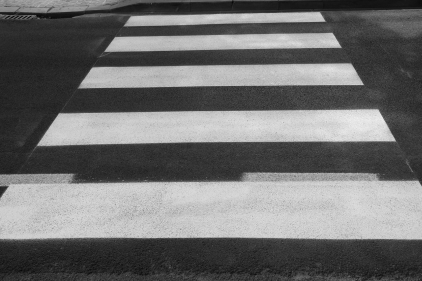

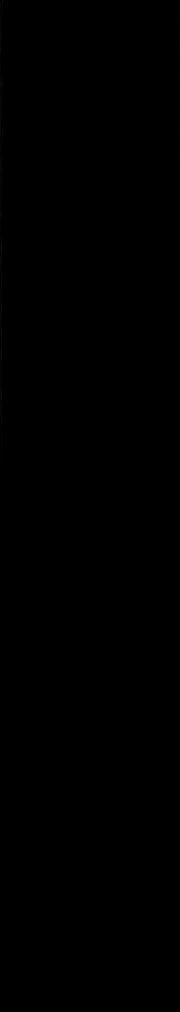

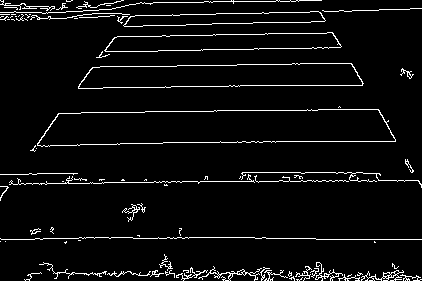

In [ ]:
image = cv2.imread('crosswalk.png', cv2.IMREAD_GRAYSCALE)
accumulator, result_image = hough_transform_with_orientation(cv2.Canny(image, 50, 150))
cv2_imshow(image)
cv2_imshow(accumulator.astype(np.uint8))
cv2_imshow(result_image)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]] [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[]
[[0 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 1]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


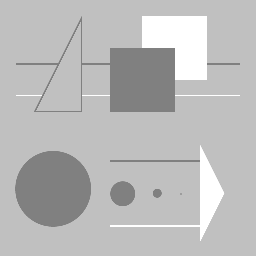

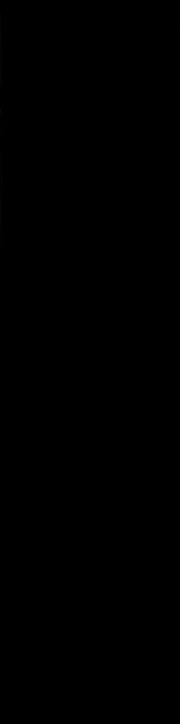

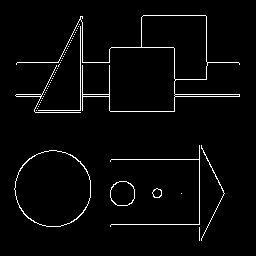

In [ ]:
image = cv2.imread('edges-lines-orig.png', cv2.IMREAD_GRAYSCALE)
accumulator, result_image = hough_transform_with_orientation(cv2.Canny(image, 50, 150))
cv2_imshow(image)
cv2_imshow(accumulator.astype(np.uint8))
cv2_imshow(result_image)

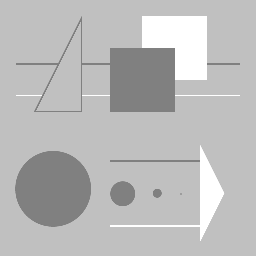

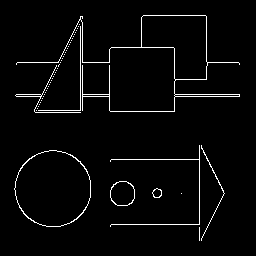

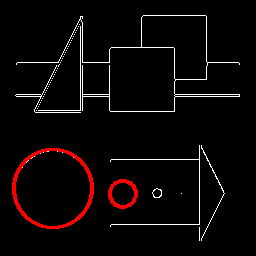

In [ ]:
def hough_transform_circles(edges, min_radius, max_radius, delta_radius=1, threshold=100, num_circles=5):
    height, width = edges.shape
    accumulator = np.zeros((height, width, max_radius - min_radius + 1), dtype=np.uint64)

    for y in range(height):
        for x in range(width):
            if edges[y, x] > 0:
                for radius in range(min_radius, max_radius + 1, delta_radius):
                    for theta in range(0, 360):
                        a = x - int(radius * np.cos(np.radians(theta)))
                        b = y - int(radius * np.sin(np.radians(theta)))
                        if 0 <= a < width and 0 <= b < height:
                            accumulator[b, a, radius - min_radius] += 1

    peaks = np.argwhere(accumulator > threshold)
    sorted_peaks = peaks[np.argsort(accumulator[peaks[:, 0], peaks[:, 1], peaks[:, 2]])[::-1]][:num_circles]

    result_image = cv2.cvtColor(edges, cv2.COLOR_GRAY2BGR)
    for peak in sorted_peaks:
        x, y, radius = peak[1], peak[0], peak[2] + min_radius
        cv2.circle(result_image, (x, y), radius, (0, 0, 255), 2)

    return accumulator, result_image

image = cv2.imread('edges-lines-orig.png', cv2.IMREAD_GRAYSCALE)
min_radius = 10
max_radius = 50
delta_radius = 1
threshold = 100
num_circles = 5
edges = cv2.Canny(image, 50, 150)
accumulator, result_image = hough_transform_circles(edges, min_radius, max_radius, delta_radius, threshold, num_circles)
cv2_imshow(image)
cv2_imshow(edges)
# cv2_imshow(accumulator.astype(np.uint8))
cv2_imshow(result_image)

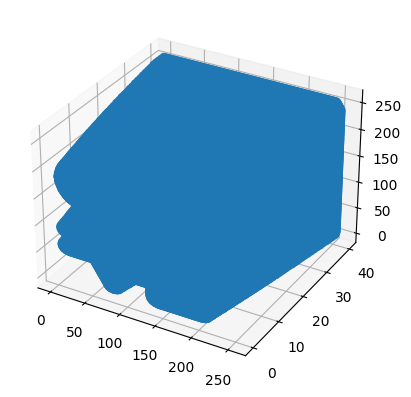

In [ ]:
from matplotlib import pyplot as plt
fig=plt.figure()
ax=plt.axes(projection='3d')
z,x,y= accumulator.nonzero()

ax.scatter(x,y,z)
plt.show()

In [ ]:
def plot_accumulator_3d(accumulator):
    fig = plt.figure(figsize=(16,10))
    ax = fig.add_subplot(111, projection='3d')

    z, y, x = accumulator.nonzero()
    ax.scatter(z, y, x, c='r', marker='o')

    plt.show()

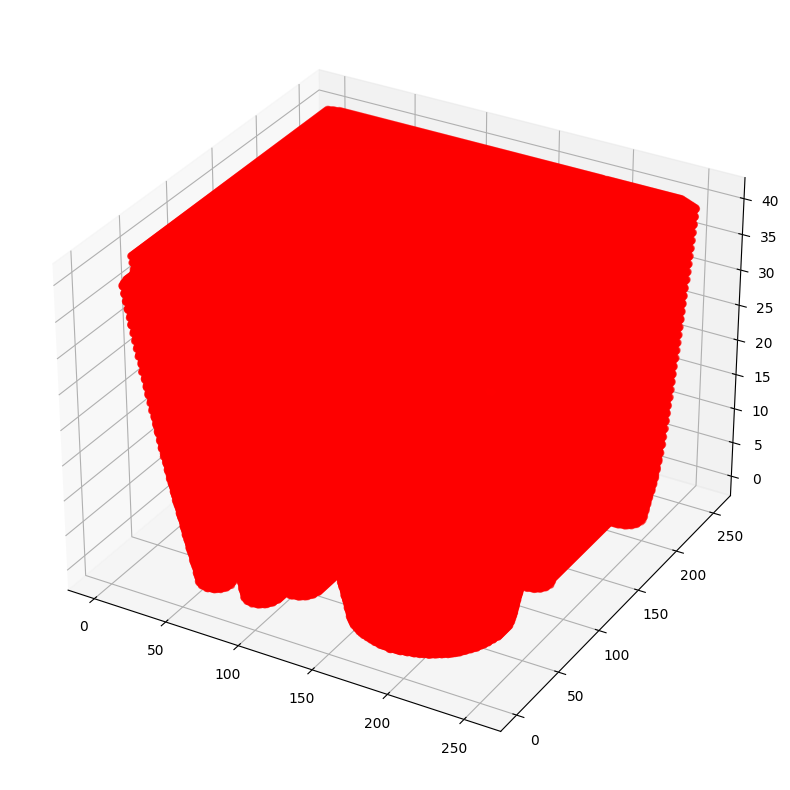

In [ ]:
plot_accumulator_3d(accumulator)